ADAPTED FROM:

https://github.com/GarrettMooney/pymc3_robust_regression

WHICH IS ADAPTED FROM:

https://twiecki.io/blog/2013/08/27/bayesian-glms-2/

# Bayesian Robust Regression in PyMC3
An extension of a [blog post](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/) by [Thomas Wiecki](https://sites.google.com/a/brown.edu/lncc/home/members) in which degrees of freedom is estimated.

In [2]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

import theano

In [3]:
size = 50
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

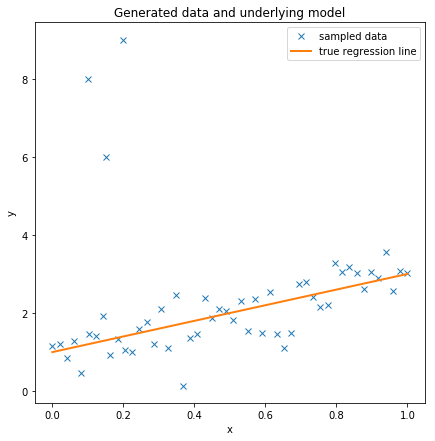

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

# Robust Regression

In [27]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2470.55draws/s]
The acceptance probability does not match the target. It is 0.8824336233283077, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
def plot_posterior_predictive(trace, eval=None, lm=None, samples=30, **kwargs):
    """Plot posterior predictive of a linear model.

    :Arguments:
        trace : <array>
            Array of posterior samples with columns
        eval : <array>
            Array over which to evaluate lm
        lm : function <default: linear function>
            Function mapping parameters at different points
            to their respective outputs.
            input: point, sample
            output: estimated value
        samples : int <default=30>
            How many posterior samples to draw.

    Additional keyword arguments are passed to pylab.plot().

    """
    import matplotlib.pyplot as plt

    if lm is None:
        lm = lambda x, sample: sample['Intercept'] + sample['x'] * x

    if eval is None:
        eval = np.linspace(0, 1, 100)

    # Set default plotting arguments
    if 'lw' not in kwargs and 'linewidth' not in kwargs:
        # kwargs['lw'] = .2
        kwargs['alpha'] = .05
    if 'c' not in kwargs and 'color' not in kwargs:
        kwargs['c'] = 'k'

    for rand_loc in np.random.randint(0, len(trace), samples):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), **kwargs)
        # Make sure to not plot label multiple times
        kwargs.pop('label', None)

    plt.title('Posterior predictive')

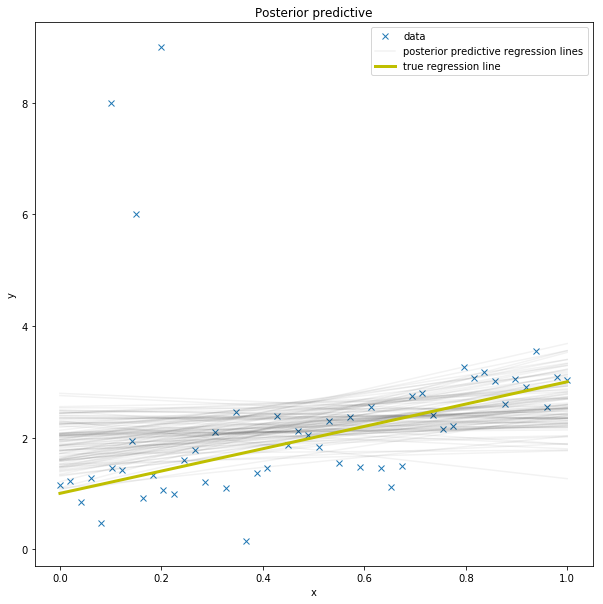

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(111, xlabel='x', ylabel='y',
           title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data',)
plot_posterior_predictive(trace, samples=100,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')

plt.legend(loc=0);

In [65]:
# pm.plot_posterior(trace)

In [34]:
# pm.traceplot(trace)

In [67]:
# pm.summary(trace)

In [74]:
# pm.pairplot(trace, var_names=['x', 'sd'], contour=False)

In [38]:
# trace.varnames

In [10]:
# trace['x']

In [40]:
# pm.plots.autocorrplot(trace)

In [76]:
# accept = np.sum(trace['x'][1:] != trace['x'][:-1])
# print("Acceptance Rate: ", float(accept)/trace['x'].shape[0])

In [80]:
# score = pm.geweke(trace, first=0.1, last=0.5, intervals=10)
# score[0]['x']

array([[ 0.00000000e+00,  1.07970238e-01],
       [ 1.11000000e+02,  1.35994229e-01],
       [ 2.22000000e+02,  6.20328535e-02],
       [ 3.33000000e+02, -8.97769445e-02],
       [ 4.44000000e+02, -8.93026961e-02],
       [ 5.55000000e+02,  1.02092596e-01],
       [ 6.66000000e+02,  2.05373538e-03],
       [ 7.77000000e+02,  4.45666010e-02],
       [ 8.88000000e+02, -4.51734713e-02]])

In [84]:
# from IPython.core.pylabtools import figsize
# import matplotlib.cm as cm

In [85]:
# score=pm.geweke(trace, first=0.1, last=0.5, intervals=20)
# scores=list(x['x'] for x in score.values())
# chains=[x[0] for x in score.items()]
# figsize(14, 11)
# colors = iter(cm.rainbow(np.linspace(0, 1, len(scores))))
# for i, label in zip(range(len(scores)), chains):
#     sx = plt.subplot(len(scores)/2, 2, i+1)
#     plt.scatter(scores[i][:,0],scores[i][:,1], marker = 'o', s=100, label=label, color=next(colors))
#     plt.axhline(-1.98, c='gray')
#     plt.axhline(1.98, c='gray')
#     plt.ylim(-2.5,2.5)
#     plt.xlim(0-10,(trace['x'].shape[0]/2+10)/10)
#     plt.legend()
# plt.suptitle('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')

In [87]:
pm.gelman_rubin(trace)

{'Intercept': 0.9999866794212455,
 'x': 0.9999891121081971,
 'sd': 0.9999872439142594}

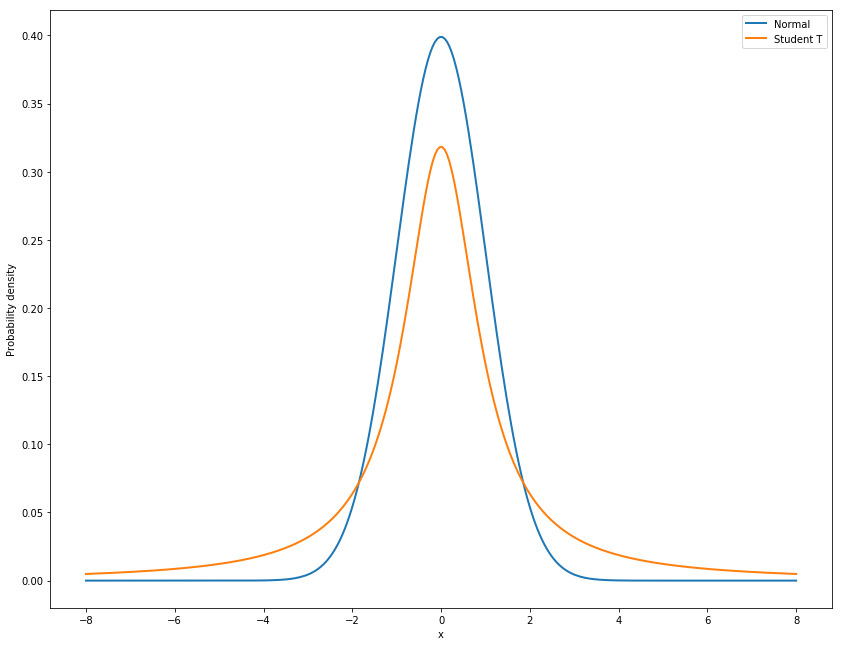

In [97]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

In [46]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, x, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2143.62draws/s]
The acceptance probability does not match the target. It is 0.8916369900776736, but should be close to 0.8. Try to increase the number of tuning steps.


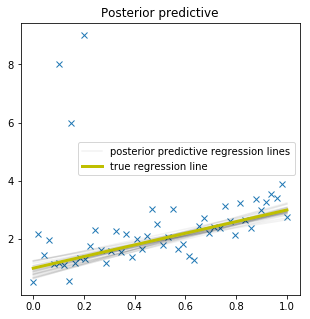

In [104]:
plt.figure(figsize=(10, 10))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive(trace_robust,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')
plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127295450>,
      dtype=object)

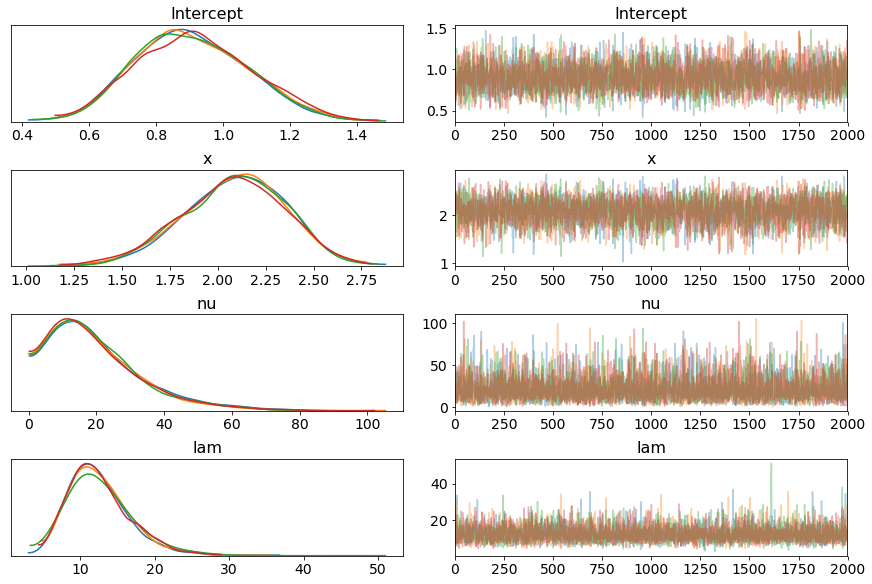

In [105]:
pm.traceplot(trace_robust)

## Extensions
How to use a prior for the degrees of freedom?

In [103]:
# %load_ext rpy2.ipython

In [101]:
# import warnings
# warnings.filterwarnings('ignore')

In [102]:
# %%R require(rethinking)

# N <- 1e5

# # Juárezd and Steel via Aki Vehtari
# gamma_prior <- rgamma(N, 2, 0.1)
# # John Kruschke
# exp_prior <- rexp(N, 1/29) + 1

# dens(gamma_prior, col = rangi2, xlab = '')
# dens(exp_prior, add = TRUE)
# mtext("Comparison of priors for student-T\'s degrees of freedom")
# legend(95, 0.035, c("gamma(2, .1)", "exp(1/29) + 1"), col = c(rangi2, 1), lty = 1)

In [106]:
with pm.Model() as model_robust:
    nu = pm.Gamma('nu', alpha=2, beta=0.1)  # Juárez and Steel prior
    # nu = pm.Exponential('nu', lam=1/29) + 1  # Kruschke prior
    family = pm.glm.families.StudentT(nu=nu)
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, x, Intercept, nu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2130.03draws/s]


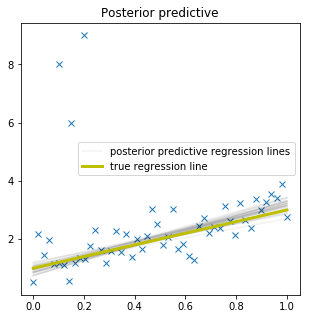

In [107]:
plt.figure(figsize=(10, 10))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive(trace_robust,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')
plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124128dd0>,
      dtype=object)

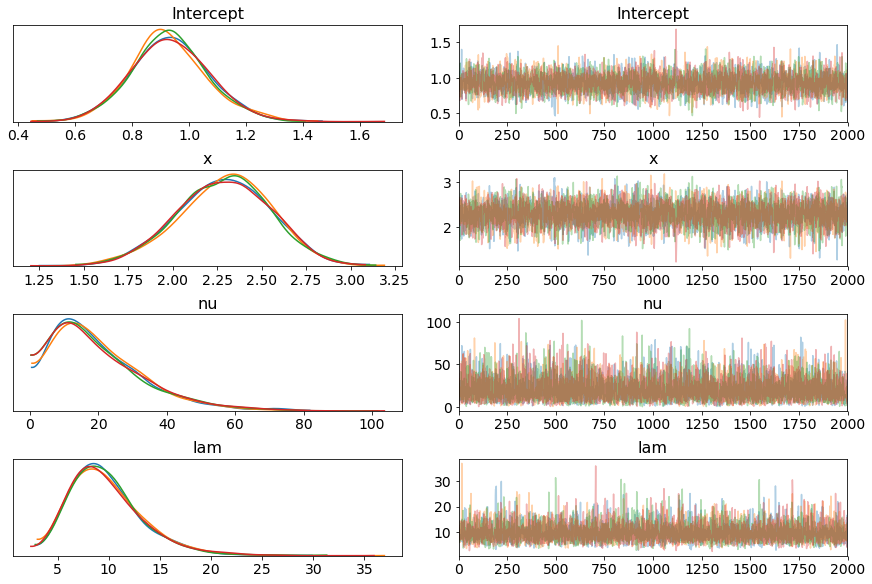

In [108]:
pm.traceplot(trace_robust)

In [21]:
with pm.Model() as model_robust:
#     nu = pm.Gamma('nu', alpha=2, beta=0.1, testval=1)  # Juárez and Steel prior
#     # nu = pm.Exponential('nu', lam=1/29) + 1  # Kruschke prior
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1)
    beta  = pm.Normal('Intercept', 0, sigma=20, testval=1)
    alpha = pm.Normal('x', 0, sigma=20, testval=1)
    y1 = pm.Normal.dist(sigma=sigma, mu=beta + alpha * x_out, shape=x_out.shape)
    
    y2 = pm.Normal.dist(mu=0, sigma=100)
    
    lam = pm.Beta('lam', alpha=1, beta=3)
    out = pm.Bernoulli('out', lam, shape=x_out.shape)
    
    y0 = pm.DensityDist('Ylike',
            lambda value: pm.math.switch(out,
                y2.logp(value),
                y1.logp(value)
            ),
            observed=y_out)
    
    print(y1.shape)
    print(y2.shape)
    print(y_out.shape)
    
    trace_robust = pm.sample(2000)

[53]
[]
(53,)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lam, x, Intercept, sigma]
>BinaryGibbsMetropolis: [out]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:18<00:00, 547.25draws/s]


In [22]:
np.mean(trace_robust.get_values(varname='out'), axis=0)

array([8.750e-04, 1.250e-04, 0.000e+00, 7.500e-04, 7.500e-04, 6.250e-04,
       7.500e-04, 1.250e-03, 6.250e-04, 1.250e-04, 5.000e-04, 1.250e-04,
       6.250e-04, 1.250e-04, 8.750e-04, 6.250e-04, 1.125e-03, 1.750e-03,
       5.750e-02, 2.500e-04, 3.750e-04, 2.500e-04, 6.250e-04, 5.000e-04,
       1.125e-03, 3.750e-04, 6.250e-04, 1.250e-04, 6.250e-04, 1.750e-03,
       5.000e-04, 1.375e-03, 7.750e-03, 1.875e-03, 6.250e-04, 7.500e-04,
       3.750e-04, 5.000e-04, 1.250e-04, 1.375e-03, 2.500e-04, 7.500e-04,
       1.250e-03, 6.250e-04, 6.250e-04, 3.750e-04, 1.000e-03, 5.000e-04,
       2.500e-04, 2.500e-04, 1.000e+00, 1.000e+00, 1.000e+00])

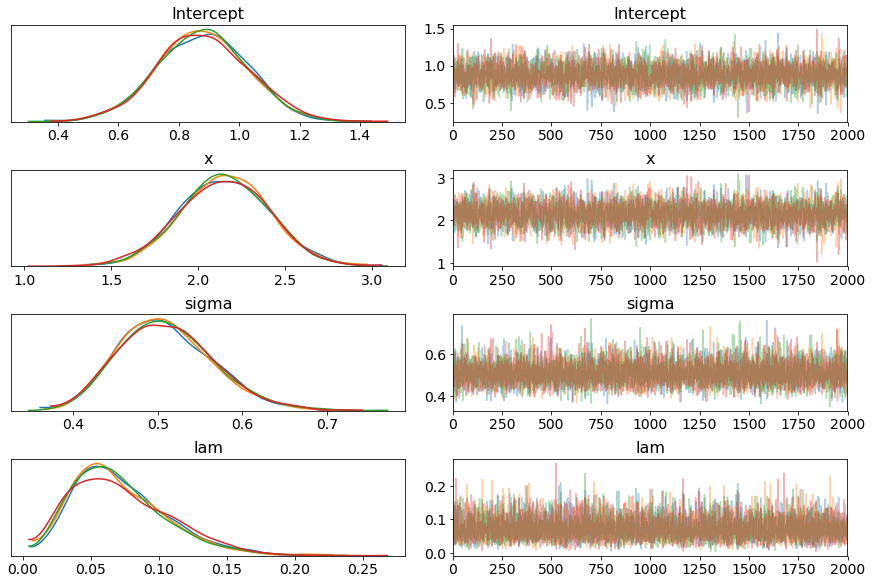

In [23]:
pm.traceplot(trace_robust, var_names=['Intercept', 'x', 'sigma', 'lam']);

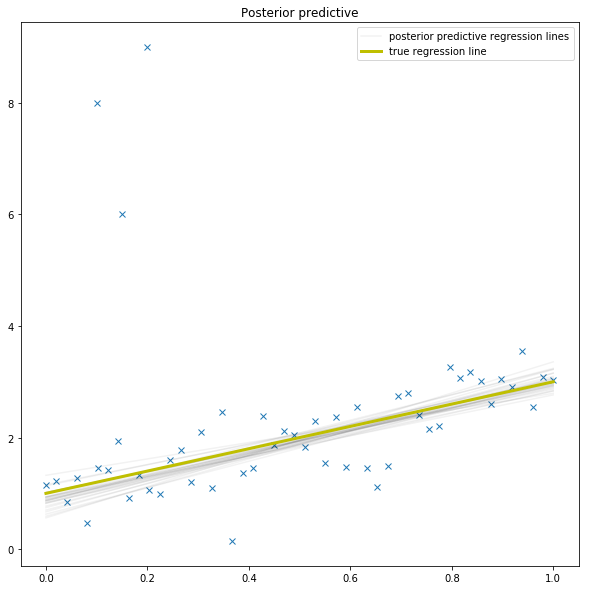

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive(trace_robust,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')
plt.legend();